In [58]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

In [ ]:
def sample_p():
    while True:
        i = sample_q()
        if np.random.random() < p[i] / ((1 + eps) * q[i]):
            return i

*Dowód poprawności*

Szansa, że $i$ zostanie wybrane w iteracji to ${q}_{{i}}\frac{{{p}_{{i}}}}{{{\left({1}+\varepsilon\right)}{q}_{{i}}}}=\frac{{p}_{{i}}}{{{1}+\varepsilon}}$.

Szansa, że iteracja nie skończy się wybraniem liczby to ${1}-\sum\frac{{p}_{{i}}}{{{1}+\varepsilon}}={1}-\frac{{1}}{{{1}+\varepsilon}}=\frac{\varepsilon}{{{1}+\varepsilon}}$.

Stąd szansa na wylosowanie $i$ w dowolnej iteracji to $\frac{{p}_{{i}}}{{{1}+\varepsilon}}+\frac{\varepsilon}{{{1}+\varepsilon}}\frac{{p}_{{i}}}{{{1}+\varepsilon}}+{\left(\frac{\varepsilon}{{{1}+\varepsilon}}\right)}^{{2}}\frac{{p}_{{i}}}{{{1}+\varepsilon}}+\ldots=\frac{{p}_{{i}}}{{{1}+\varepsilon}}{\sum_{{{n}={0}}}^{{\infty}}}{\left(\frac{\varepsilon}{{{1}+\varepsilon}}\right)}^{{n}}={p}_{{i}}$

In [52]:
births = pd.read_csv("../lab1/us_births_69_88.csv")["births"]
births

0      160369
1      169896
2      180036
3      182854
4      184145
        ...  
367    194006
368    201768
369    204806
370    206894
371    194368
Name: births, Length: 372, dtype: int64

In [53]:
births_sum = np.sum(births)
p = (births / births_sum).rename("p[i]")
print("p =")
print(p)
print(f"sum(p) = {sum(p)} = 1")

n = len(p)
print(f"n = {n}")

p =
0      0.002275
1      0.002410
2      0.002554
3      0.002594
4      0.002612
         ...   
367    0.002752
368    0.002863
369    0.002906
370    0.002935
371    0.002758
Name: p[i], Length: 372, dtype: float64
sum(p) = 0.9999999999999999 = 1
n = 372


In [54]:
q = np.repeat(1 / n, n)
sample_q = lambda: np.random.randint(n)
print("q =")
print(q[:20], "...")
print(f"sum(q) = {sum(q)} = 1")

eps = max(p[i] / q[i] - 1 for i in range(n))
assert np.all(p <= (1 + eps) * q), "p[i] <= (1 + eps)/q[i] condition not met"
print(f"eps = {eps}")

q =
[0.00268817 0.00268817 0.00268817 0.00268817 0.00268817 0.00268817
 0.00268817 0.00268817 0.00268817 0.00268817 0.00268817 0.00268817
 0.00268817 0.00268817 0.00268817 0.00268817 0.00268817 0.00268817
 0.00268817 0.00268817] ...
sum(q) = 0.9999999999999992 = 1
eps = 0.12368095025464299


In [55]:
def until_collision():
    s = set()
    while True:
        x = sample_p()
        if x in s:
            return len(s)
        s.add(x)

sample = [until_collision() for _ in range(100000)]

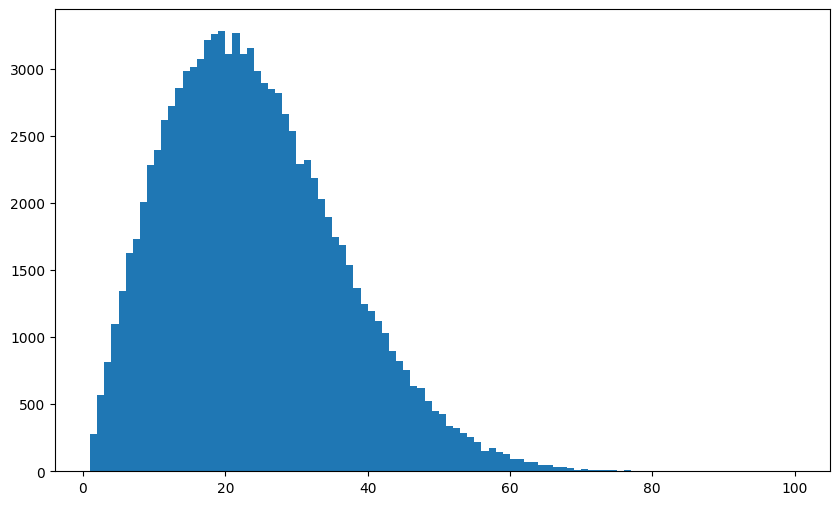

Couple first most likely values: [19 21 18 17 23 20 22 16 15 24]
Average value: 23.64543


In [56]:
plt.figure(figsize=(10, 6))
plt.hist(sample, bins=range(1, 101))
plt.show()

vals, counts = np.unique(sample, return_counts=True)
k_counts = vals[np.argsort(counts)][::-1]

print('Couple first most likely values: {}'.format(k_counts[:10]))

print(f"Average value: {(np.mean(sample))}")


**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [57]:
% % time

import numpy as np

X = np.array([10, 3, 7])
I = np.array([1, 1, 2, 2])
print(X[I])
X = np.array([[1, 2], [3, 4]])
I = np.array([0, 0, 1])
J = np.array([1, 0, 1])
print(X[I, J])

UsageError: Line magic function `%` not found.


**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of at most two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.